# I. Imports and some functions for plotting (Skip reading this)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
device = torch.device("cpu")
import torch
import torch.func as TF
from functorch import jacrev,jacfwd
import matplotlib.pyplot as plt
import timeit
import functools

In [2]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x
    
decoder = Decoder(encoded_space_dim = 2,fc2_input_dim=128)

# Send to device
decoder.to(device) 

# Load the parameters of the trained decoder without curvature in Loss func
PATH_dec = '../nn_weights/decoder_conv_autoenc.pt'
decoder.load_state_dict(torch.load(PATH_dec))

# Switch to eval mode
decoder.eval()

Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [3]:
def make_grid(numsteps, xshift = 0.0, yshift = 0.0):
    
    xs = torch.linspace(-1.5, 1.5, steps = numsteps) + xshift
    ys = torch.linspace(-1.5, 1.5, steps = numsteps) + yshift
    #uniform_grid = torch.cartesian_prod(xs,ys)

    # true grid starts from left bottom corner. x is the first to increase
    tgrid = torch.cartesian_prod(ys, xs)
    tgrid = tgrid.roll(1,1)
    return tgrid

In [4]:
def draw_frob_norm_tensor_on_grid(plot_name,tensor_on_grid, numsteps = 100,xshift = 0.0, yshift = 0.0):
    Frob_norm_on_grid = tensor_on_grid.norm(dim=(1,2)).view(numsteps,numsteps)
    #Frob_norm_on_grid = metric_on_grid.norm(dim=(1,2)).view(numsteps,numsteps)
    Frob_norm_on_grid = Frob_norm_on_grid[1:-1,1:-1].detach()

    fig, ax = plt.subplots()
    im = ax.imshow(Frob_norm_on_grid,origin="lower")

    cbar = ax.figure.colorbar(im)
    
    ax.set_xticks((Frob_norm_on_grid.shape[0]-1)*(np.linspace(0,1,num=11)),labels=(np.linspace(-1.5,1.5,num=11)+xshift).round(1))
    ax.set_yticks((Frob_norm_on_grid.shape[1]-1)*(np.linspace(0,1,num=11)),labels=(np.linspace(-1.5,1.5,num=11)+yshift).round(1))
    plt.xlabel( "x coordinate")
    plt.ylabel( "y coordinate")
    plt.axis('scaled')

    ax.set_title(plot_name)
    fig.tight_layout()
    plt.show()
    return plt

# II. Tensors computed with higher order derivatives using jacfwd

In [5]:
def metric_jacfwd(u, function = decoder, latent_space_dim=2):
    u = u.reshape(-1,latent_space_dim)
    jac = jacfwd(function)(u)
    jac = jac.reshape(-1,latent_space_dim)
    metric = torch.matmul(jac.T,jac)
    return metric

metric_jacfwd_vmap = TF.vmap(metric_jacfwd)

In [6]:
# The variable wrt which 
# the derivative is computed is the last index
def metric_der_jacfwd (u, function = decoder):
    metric = functools.partial(metric_jacfwd, function=function)
    dg = jacfwd(metric)(u).squeeze()
    # squeezing is needed to get rid of 1-dimentions 
    # occuring when using jacfwd
    return dg

In [7]:
def Ch_jacfwd (u, function = decoder):
    g = metric_jacfwd(u,function)
    g_inv = torch.inverse(g)
    dg = metric_der_jacfwd(u,function)
    Ch = 0.5*(torch.einsum('im,mkl->ikl',g_inv,dg)+
              torch.einsum('im,mlk->ikl',g_inv,dg)-
              torch.einsum('im,klm->ikl',g_inv,dg)
              )
    return Ch
Ch_jacfwd_vmap = TF.vmap(Ch_jacfwd)

In [8]:
def Ch_der_jacfwd (u, function = decoder):
    Ch = functools.partial(Ch_jacfwd, function=function)
    dCh = jacfwd(Ch)(u).squeeze()
    return dCh
Ch_der_jacfwd_vmap = TF.vmap(Ch_der_jacfwd)

In [9]:
# Riemann curvature tensor (3,1)
def Riem_jacfwd(u, function = decoder):
    Ch = Ch_jacfwd(u, function)
    Ch_der = Ch_der_jacfwd(u, function)

    Riem = torch.einsum("iljk->ijkl",Ch_der) - torch.einsum("ikjl->ijkl",Ch_der)
    Riem += torch.einsum("ikp,plj->ijkl", Ch, Ch) - torch.einsum("ilp,pkj->ijkl", Ch, Ch)
    return Riem

In [10]:
def Ric_jacfwd(u, function = decoder):
    Riemann = Riem_jacfwd(u, function)
    Ric = torch.einsum("cacb->ab",Riemann)
    return Ric
Ric_jacfwd_vmap = TF.vmap(Ric_jacfwd)

In [11]:
# demo
Ric_jacfwd_vmap(torch.rand(3,2))

/home/alazarev/CodeProjects/ricci_regularization/.venv_ricci/lib/python3.10/site-packages/torch-2.0.1-py3.10-linux-x86_64.egg/torch/_functorch/deprecated.py:85: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacfwd is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacfwd instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('jacfwd')


tensor([[[-0.1227,  0.0806],
         [ 0.0806, -0.1048]],

        [[-0.0194,  0.0039],
         [ 0.0039, -0.0138]],

        [[-0.8872,  0.0021],
         [ 0.0021, -0.5990]]], grad_fn=<SumBackward1>)

# III. Ground truth check

In [12]:
# metric generating functions
# u = (\theta, \phi)
# ds^2 = (d\theta)^2 + sin^2(\theta)*(d\phi)^2
def my_fun_sphere(u):
    u = u.flatten()
    
    x = torch.sin(u[0])*torch.cos(u[1])
    y = torch.sin(u[0])*torch.sin(u[1])
    z = torch.cos(u[0])

    x = x.unsqueeze(0)
    y = y.unsqueeze(0)
    z = z.unsqueeze(0)
    output = torch.cat((x, y, z),dim=-1)
    output = torch.cat((output.unsqueeze(0),torch.zeros(781).unsqueeze(0)),dim=1)
    output = output.flatten()
    return output

# Partial embedding (for y>c) of Lobachevsky plane to R^3 
# (formally here it is R^784)
# ds^2 = 1/y^2(dx^2 + dy^2)
# http://www.antoinebourget.org/maths/2018/08/08/embedding-hyperbolic-plane.html
def my_fun_lobachevsky(u, c=0.01):
    u = u.flatten()
    x = u[0]
    y = u[1]
    t = torch.acosh(y/c)
    x0 = t - torch.tanh(t)
    x1 = (1/torch.sinh(t))*torch.cos(x/c)
    x2 = (1/torch.sinh(t))*torch.sin(x/c)
    output = torch.cat((x0.unsqueeze(0),x1.unsqueeze(0),x2.unsqueeze(0)),dim=-1)
    output = torch.cat((output.unsqueeze(0),torch.zeros(781).unsqueeze(0)),dim=1)
    output = output.flatten()
    return output

In [13]:
# metric tensor and ricci tensor ground truth
# ds^2 = (d\theta)^2 + sin^2(\theta)*(d\phi)^2
def metric_sphere(u):
    u = u.flatten()
    #print("\n", u.dtype)
    theta = u[0]
    phi = u[1]
    #metric_tensor = torch.diag(torch.tensor([1.0,0.0])) + torch.diag(torch.Tensor([0.0,1.0]))*(torch.sin(theta))**2
    E_11 = torch.diag(torch.tensor([1.0,0.0],dtype=float))
    E_22 = torch.diag(torch.tensor([0.0,1.0],dtype=float))
    
    metric_tensor = E_11 + E_22*(torch.sin(theta))**2
    #print("\n", metric_tensor.dtype)
    return metric_tensor 
metric_sphere_vmap = TF.vmap(metric_sphere)

In [14]:
# Motivating demo
torch.manual_seed(10)
test_batch = torch.rand(3,2,dtype=float)
metric_jacfwd_example = Ric_jacfwd_vmap(test_batch,
                                      function=my_fun_sphere)
metric_exact_example = metric_sphere_vmap(test_batch)
print("metric via jacfwd:\n", metric_jacfwd_example)
print("metric via exact formula:\n", metric_exact_example)
print("Absolute error:\n", metric_jacfwd_example - metric_exact_example)

metric via jacfwd:
 tensor([[[ 1.0000e+00,  2.3504e-18],
         [-3.0815e-33,  3.8045e-01]],

        [[ 1.0000e+00,  1.5318e-17],
         [ 2.7756e-17,  4.2645e-01]],

        [[ 1.0000e+00,  9.9301e-18],
         [ 0.0000e+00,  6.5440e-01]]], dtype=torch.float64)
metric via exact formula:
 tensor([[[1.0000, 0.0000],
         [0.0000, 0.3804]],

        [[1.0000, 0.0000],
         [0.0000, 0.4264]],

        [[1.0000, 0.0000],
         [0.0000, 0.6544]]], dtype=torch.float64)
Absolute error:
 tensor([[[ 0.0000e+00,  2.3504e-18],
         [-3.0815e-33, -1.1102e-16]],

        [[ 0.0000e+00,  1.5318e-17],
         [ 2.7756e-17,  5.5511e-17]],

        [[-3.3307e-16,  9.9301e-18],
         [ 0.0000e+00,  0.0000e+00]]], dtype=torch.float64)


Shapes:
torch.Size([1000])
Absolute error:
tensor(8.9737e-17, dtype=torch.float64) tensor(4.4454e-16, dtype=torch.float64)
Relative error:
tensor(8.5438e-15, dtype=torch.float64) tensor(4.4440e-14, dtype=torch.float64)


(array([420., 112., 257.,  13., 161.,  29.,   0.,   4.,   0.,   4.]),
 array([0.00000000e+00, 4.44401871e-15, 8.88803742e-15, 1.33320561e-14,
        1.77760748e-14, 2.22200936e-14, 2.66641123e-14, 3.11081310e-14,
        3.55521497e-14, 3.99961684e-14, 4.44401871e-14]),
 <BarContainer object of 10 artists>)

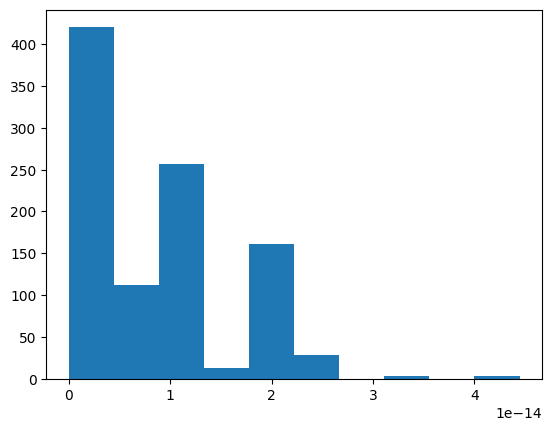

In [15]:
# Historgam of errors. This is done in order to verify Ricci 
# tensor computation. Ric = k*g,with k = n-1 for an 
# n-dimentional sphere S^n. Thus if n = 2, Ric = g
torch.manual_seed(10)

#test_batch = torch.rand(1000,2)
test_batch = torch.rand(1000,2,dtype=float)
#test_batch.to(torch.float64)

#test_batch = torch.rand(1000,2) @ torch.diag( torch.tensor( [torch.pi, 2*torch.pi] ) )
# Capping
#test_batch[:,0]   = 0.1 + 0.8*test_batch[:,0]
test_metric_jacfwd_array = metric_jacfwd_vmap(test_batch,
                                       function=my_fun_sphere)
test_metric_exact_array = metric_sphere_vmap(test_batch)

# here we check the error in exact metric computation and jacfwd
absolute_error = (test_metric_jacfwd_array - test_metric_exact_array).norm(dim=(1,2))
relative_error = 100*absolute_error/(test_metric_exact_array.norm(dim=(1,2)))

print( "Shapes:")
print( absolute_error.shape )
print( "Absolute error:")
print( absolute_error.mean(), absolute_error.max() )
print( "Relative error:")
print( relative_error.mean(), relative_error.max() )

plt.hist(relative_error,bins=10,density=False,stacked=True)

Shapes:
torch.Size([1000])
Absolute error:
tensor(9.4114e-13, dtype=torch.float64) tensor(4.6566e-10, dtype=torch.float64)
Relative error:
tensor(9.4112e-11, dtype=torch.float64) tensor(4.6566e-08, dtype=torch.float64)


(array([996.,   1.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([3.16351310e-18, 4.65661289e-09, 9.31322577e-09, 1.39698387e-08,
        1.86264515e-08, 2.32830644e-08, 2.79396773e-08, 3.25962902e-08,
        3.72529031e-08, 4.19095159e-08, 4.65661288e-08]),
 <BarContainer object of 10 artists>)

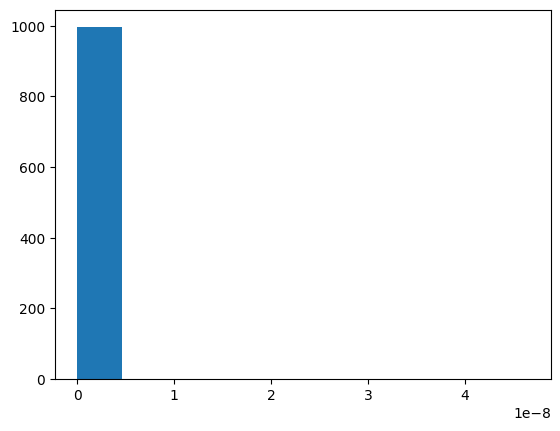

In [16]:
# Historgam of errors. This is done in order to verify Ricci 
# tensor computation. Ric = k*g,with k = n-1 for an 
# n-dimentional sphere S^n. Thus if n = 2, Ric = g
torch.manual_seed(10)

test_batch = torch.rand(1000,2, dtype=float)

#test_batch = torch.rand(1000,2) @ torch.diag( torch.tensor( [torch.pi, 2*torch.pi] ) )
# Capping
#test_batch[:,0]   = 0.1 + 0.8*test_batch[:,0]
test_Ricci_jacfwd_array = Ric_jacfwd_vmap(test_batch,
                                       function=my_fun_sphere)
test_metric_exact_array = metric_sphere_vmap(test_batch)

# here we check the error in exact metric computation and jacfwd
absolute_error = (test_Ricci_jacfwd_array - test_metric_exact_array).norm(dim=(1,2))
relative_error = 100*absolute_error/(test_metric_exact_array.norm(dim=(1,2)))

print( "Shapes:")
print( absolute_error.shape )
print( "Absolute error:")
print( absolute_error.mean(), absolute_error.max() )
print( "Relative error:")
print( relative_error.mean(), relative_error.max() )

plt.hist(relative_error,bins=10,density=False,stacked=True)

# IV. Comparing metric and Ricci tensors for Einstein metrics

### Sphere

In [17]:
# Motivating demo
torch.manual_seed(10)
test_batch = torch.rand(3,2)
print("metric:\n", metric_jacfwd_vmap(test_batch,
                                      function=my_fun_sphere))
print("Ricci tensor:\n", Ric_jacfwd_vmap(test_batch,
                                      function=my_fun_sphere))

metric:
 tensor([[[1.0000, 0.0000],
         [0.0000, 0.1956]],

        [[1.0000, 0.0000],
         [0.0000, 0.0945]],

        [[1.0000, 0.0000],
         [0.0000, 0.0451]]])
Ricci tensor:
 tensor([[[1.0000, 0.0000],
         [0.0000, 0.1956]],

        [[1.0000, 0.0000],
         [0.0000, 0.0945]],

        [[1.0000, 0.0000],
         [0.0000, 0.0451]]])


Shapes:
torch.Size([1000])
Absolute error:
tensor(3.5578e-07) tensor(1.5260e-05)
Relative error:
tensor(3.3968e-05) tensor(0.0015)


(array([954.,  20.,  14.,   0.,   3.,   6.,   0.,   1.,   0.,   2.]),
 array([0.        , 0.00015258, 0.00030516, 0.00045774, 0.00061032,
        0.0007629 , 0.00091548, 0.00106807, 0.00122065, 0.00137323,
        0.00152581]),
 <BarContainer object of 10 artists>)

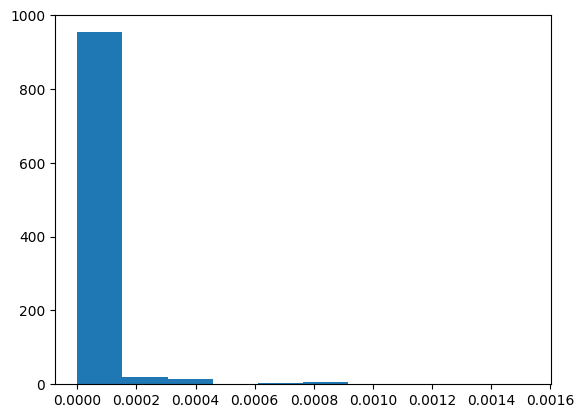

In [18]:
# Historgam of errors. This is done in order to verify Ricci 
# tensor computation. Ric = k*g,with k = n-1 for an 
# n-dimentional sphere S^n. Thus if n = 2, Ric = g
torch.manual_seed(10)

test_batch = torch.rand(1000,2) @ torch.diag( torch.tensor( [torch.pi, 2*torch.pi] ) )
# Capping
test_batch[:,0]   = 0.1 + 0.8*test_batch[:,0]
test_metric_array = metric_jacfwd_vmap(test_batch,
                                       function=my_fun_sphere)
test_Ric_array = Ric_jacfwd_vmap(test_batch,
                                       function=my_fun_sphere)

# here we check if g = Ric
absolute_error = (test_metric_array - test_Ric_array).norm(dim=(1,2))
relative_error = 100*absolute_error/(test_metric_array.norm(dim=(1,2)))

print( "Shapes:")
print( absolute_error.shape )
print( "Absolute error:")
print( absolute_error.mean(), absolute_error.max() )
print( "Relative error:")
print( relative_error.mean(), relative_error.max() )

plt.hist(relative_error,bins=10,density=False,stacked=True)

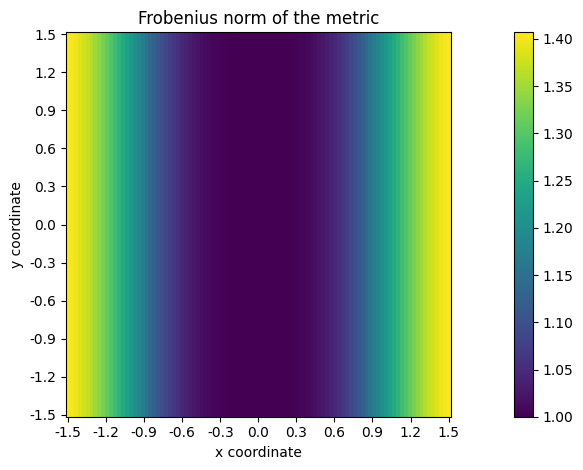

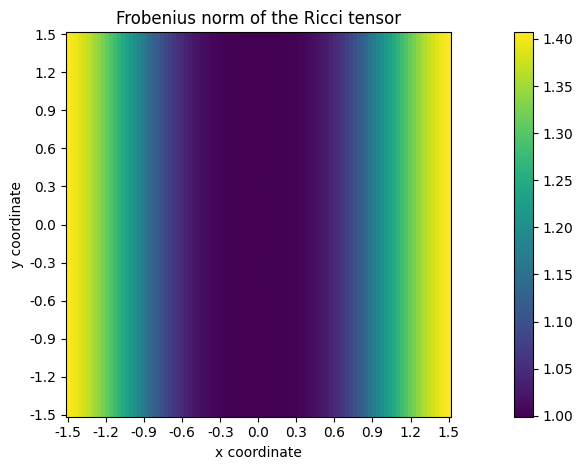

<module 'matplotlib.pyplot' from '/home/alazarev/CodeProjects/ricci_regularization/.venv_ricci/lib/python3.10/site-packages/matplotlib-3.7.2-py3.10-linux-x86_64.egg/matplotlib/pyplot.py'>

In [19]:
# compare frobenius norm heatmaps of the metric 
# and the Ricci tensor. For the sphere they should coincide
numsteps = 100
tgrid = make_grid(numsteps)
Ric_on_grid = Ric_jacfwd_vmap(tgrid, function=my_fun_sphere)
metric_on_grid = metric_jacfwd_vmap(tgrid, function=my_fun_sphere)

draw_frob_norm_tensor_on_grid(plot_name = 'Frobenius norm of the metric',
                              tensor_on_grid= metric_on_grid, 
                              numsteps=numsteps)
draw_frob_norm_tensor_on_grid(plot_name = 'Frobenius norm of the Ricci tensor',
                              tensor_on_grid= Ric_on_grid, 
                              numsteps=numsteps)

### Lobachevsky plane

In [20]:
# Motivating demo
torch.manual_seed(10)
test_batch = torch.rand(3,2)
print("metric:\n", metric_jacfwd_vmap(test_batch,
                                      function=my_fun_lobachevsky))
print("Ricci tensor:\n", Ric_jacfwd_vmap(test_batch,
                                      function=my_fun_lobachevsky))

metric:
 tensor([[[4.2909e+00, 3.4694e-18],
         [3.4694e-18, 4.2891e+00]],

        [[2.6444e+00, 8.6736e-19],
         [8.6736e-19, 2.6437e+00]],

        [[5.8997e+00, 0.0000e+00],
         [0.0000e+00, 5.8962e+00]]], dtype=torch.float64)
Ricci tensor:
 tensor([[[-4.2983e+00, -1.9797e-15],
         [-1.0994e-17, -4.2964e+00]],

        [[-2.6472e+00,  1.0217e-15],
         [-4.3429e-19, -2.6465e+00]],

        [[-5.9136e+00, -3.1200e-15],
         [-9.2127e-18, -5.9101e+00]]], dtype=torch.float64)


Shapes:
torch.Size([1000])
Absolute error:
tensor(0.0237, dtype=torch.float64) tensor(0.3376, dtype=torch.float64)
Relative error:
tensor(0.1655, dtype=torch.float64) tensor(0.9760, dtype=torch.float64)


(array([636., 139.,  69.,  50.,  23.,  19.,  19.,  21.,  11.,  13.]),
 array([0.02778982, 0.12261228, 0.21743474, 0.3122572 , 0.40707966,
        0.50190212, 0.59672458, 0.69154704, 0.7863695 , 0.88119196,
        0.97601442]),
 <BarContainer object of 10 artists>)

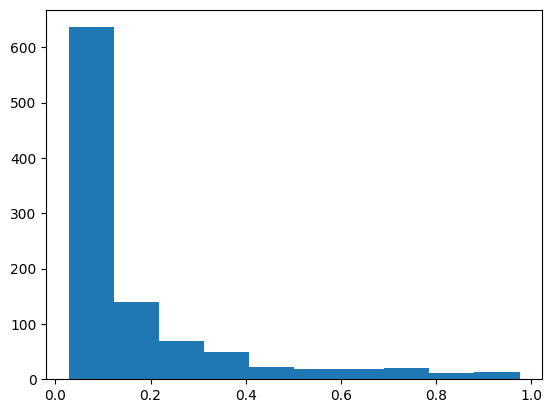

In [21]:
# Historgam of errors. This is done in order to verify Ricci 
# tensor computation. Ric = k*g,with k = -1 
# for the Lobachevsky plane. Thus if Ric = -g
torch.manual_seed(10)

test_batch = torch.rand(1000,2) + 0.2 
# we use shift because y>0 for this model

test_metric_array = metric_jacfwd_vmap(test_batch,
                                       function=my_fun_lobachevsky)
test_Ric_array = Ric_jacfwd_vmap(test_batch,
                                       function=my_fun_lobachevsky)

# here we check if g = - Ric
absolute_error = (test_metric_array + test_Ric_array).norm(dim=(1,2))
relative_error = 100*absolute_error/(test_metric_array.norm(dim=(1,2)))

print( "Shapes:")
print( absolute_error.shape )
print( "Absolute error:")
print( absolute_error.mean(), absolute_error.max() )
print( "Relative error:")
print( relative_error.mean(), relative_error.max() )



plt.hist(relative_error,bins=10,density=False,stacked=True)

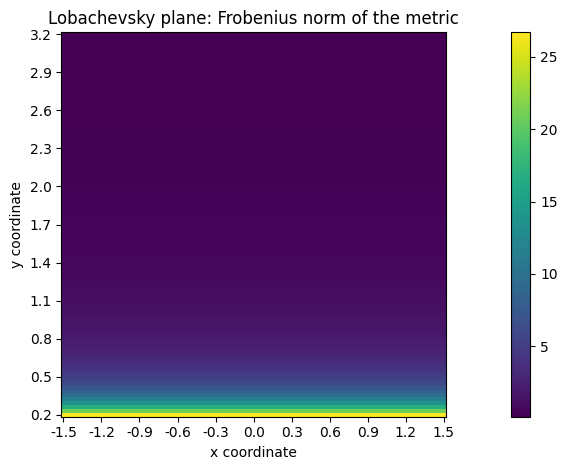

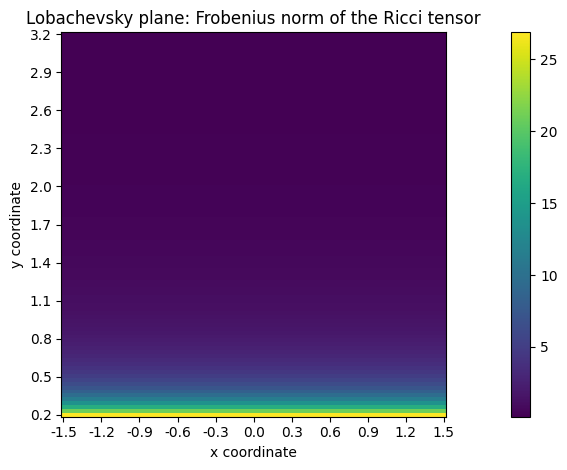

<module 'matplotlib.pyplot' from '/home/alazarev/CodeProjects/ricci_regularization/.venv_ricci/lib/python3.10/site-packages/matplotlib-3.7.2-py3.10-linux-x86_64.egg/matplotlib/pyplot.py'>

In [22]:
# compare frobenius norm heatmaps of the metric 
# and the Ricci tensor. For the Lobachevsky plane they should coincide
numsteps = 100
tgrid = make_grid(numsteps, xshift=0.0, yshift=1.7)

lobachevsky_metric_on_grid = metric_jacfwd_vmap(tgrid, function=my_fun_lobachevsky)
lobachevsky_Ric_on_grid = Ric_jacfwd_vmap(tgrid, function=my_fun_lobachevsky)

draw_frob_norm_tensor_on_grid(plot_name = 'Lobachevsky plane: Frobenius norm of the metric',
                              tensor_on_grid=lobachevsky_metric_on_grid,
                            numsteps= numsteps, xshift=0.0, yshift=1.7)
draw_frob_norm_tensor_on_grid(plot_name = 'Lobachevsky plane: Frobenius norm of the Ricci tensor',
                              tensor_on_grid=lobachevsky_Ric_on_grid,
                            numsteps= numsteps, xshift=0.0, yshift=1.7)


# V. The Ricci tensor for the metric given by the pullback of the decoder

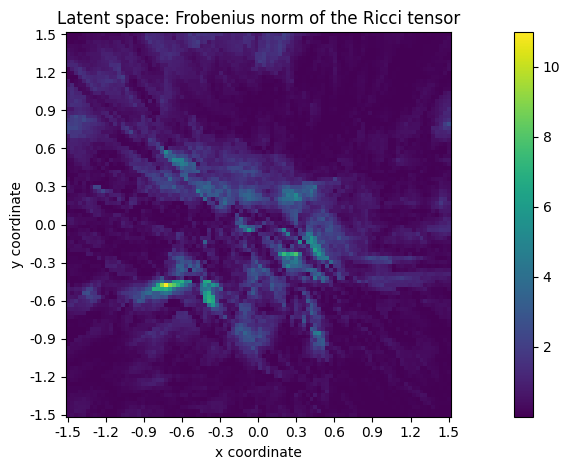

<module 'matplotlib.pyplot' from '/home/alazarev/CodeProjects/ricci_regularization/.venv_ricci/lib/python3.10/site-packages/matplotlib-3.7.2-py3.10-linux-x86_64.egg/matplotlib/pyplot.py'>

In [23]:
# this takes around 17 secs
numsteps = 100
grid = make_grid(numsteps)
Decoder_Ric_on_grid = Ric_jacfwd_vmap(grid,function=decoder)
draw_frob_norm_tensor_on_grid(plot_name='Latent space: Frobenius norm of the Ricci tensor',
                              tensor_on_grid=Decoder_Ric_on_grid,
                              numsteps=numsteps)

# VI. Newton method convergence etc.

In [24]:
x = 5.0
n = 1000000
# Ground truth
y = np.exp(x)
print( y )
# Approx
z = (1+x/n)**n
print( z )
print( "Error: ", y-z)


148.4131591025766
148.41130396072768
Error:  0.0018551418489209937


In [25]:
# Ground truth 
y = np.sqrt(x)
print( "Ground truth ")
print( y )
# Approx via Newton-Raphson
z = x
for i in range(7):
    print( "" )
    #print( "Iteration ", i)
    z = 0.5*( z + x/z )
    print( z )
    print( "Error: ", y-z) 


Ground truth 
2.23606797749979

3.0
Error:  -0.7639320225002102

2.3333333333333335
Error:  -0.09726535583354368

2.238095238095238
Error:  -0.0020272605954483325

2.2360688956433634
Error:  -9.18143573613861e-07

2.236067977499978
Error:  -1.8829382497642655e-13

2.23606797749979
Error:  0.0

2.23606797749979
Error:  0.0


# VII. Understanding how precision works

In [26]:
test_tensor = torch.rand(10)
h = 0.0001

cos_fd = lambda x: (torch.sin(x+h)-torch.sin(x))/h

cos_jacfwd = jacfwd(torch.sin)
cos_jacfwd_vmap = TF.vmap(cos_jacfwd)

result_jacfwd = cos_jacfwd_vmap(test_tensor)
result_fd = cos_fd(test_tensor)
result_exact = torch.cos(test_tensor)

absolute_error = result_fd-result_exact

relative_error = 100*absolute_error/result_exact

print( "Absolute error fd vs exact:")
print( absolute_error.mean(), absolute_error.max() )
print( "Relative error fd vs exact:")
print( relative_error.mean(), relative_error.max() )


absolute_error = result_jacfwd-result_exact

relative_error = 100*absolute_error/result_exact

print( "Absolute error jacfwd vs exact:")
print( absolute_error.mean(), absolute_error.max() )
print( "Relative error jacfwd vs exact:")
print( relative_error.mean(), relative_error.max() )

Absolute error fd vs exact:
tensor(-1.9592e-05) tensor(0.0003)
Relative error fd vs exact:
tensor(-0.0031) tensor(0.0312)
Absolute error jacfwd vs exact:
tensor(0.) tensor(0.)
Relative error jacfwd vs exact:
tensor(0.) tensor(0.)


In [27]:
ex = torch.tensor([1e-6])
# float32 by default
#ex = torch.tensor([1e-6],dtype=float)

In [28]:
ex*=0.1
print(ex)
print("{:.20f}".format(float(ex+1)))

tensor([1.0000e-07])
1.00000011920928955078
